In [10]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import make_grid
print(f'{torchvision.__version__=}')

import matplotlib.pyplot as plt
import numpy as np


torchvision.__version__='0.22.1+cu126'


In [11]:
print("GPU name:", torch.cuda.get_device_name())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print(torch.cuda.device_count(), "GPUs available")

GPU name: NVIDIA GeForce RTX 3070 Ti
Device: cuda
1 GPUs available


# Load MNIST Dataset

Training dataset 60000 samples
Test dataset 10000 samples


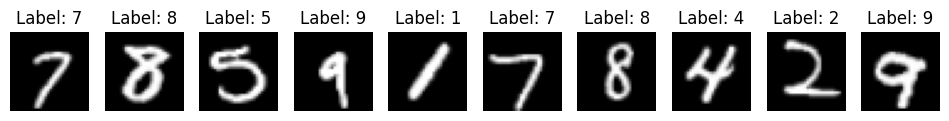

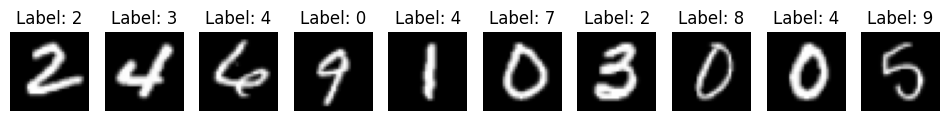

In [23]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.5,), std=(0.5,))])
training_data = datasets.MNIST(root='./data_src', train=True, download=True,transform=transform)
test_data = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)

# show random samples from the dataset
print(f"Training dataset {len(training_data)} samples")
fig, axes = plt.subplots(1, 10, figsize=(12, 4))
for ax in axes.ravel():
    idx = np.random.randint(len(training_data))
    ax.imshow(training_data[idx][0].squeeze(), cmap='gray')
    ax.set_title(f'Label: {training_data[idx][1]}')
    ax.axis('off')

print(f"Test dataset {len(test_data)} samples")
fig, axes = plt.subplots(1, 10, figsize=(12, 4))
for ax in axes.ravel():
    idx = np.random.randint(len(test_data))
    ax.imshow(test_data[idx][0].squeeze(), cmap='gray')
    ax.set_title(f'Label: {training_data[idx][1]}')
    ax.axis('off')

In [24]:
# Define dataloaders
training_dataloader = DataLoader(training_data,
                                 batch_size=64,
                                 shuffle=True,
                                 drop_last=True)
test_dataloader = DataLoader(test_data,
                             batch_size=64,
                             shuffle=False,
                             drop_last=True)

In [30]:
# Say we want 1000 diffusion steps
T = 1000
# Create a beta schedule that goes from 1e-4 to 0.02
betas = torch.linspace(1e-4, 0.02, T)
alphas = 1. - betas
alpha_hat = torch.cumprod(alphas, dim=0) # cumulative product

def q_sample(x_0, t, noise=None):
    """
    Forward diffusion (adding noise) step
    x0: original image [batch, 1, 28, 28]
    t: timestep [batch]
    """
    if noise is None:
        noise = torch.randn_like(x_0)
    sqrt_alpha_hat = torch.sqrt(alpha_hat[t])[:, None, None, None]
    sqrt_one_minus_alpha_hat = torch.sqrt(1 - alpha_hat[t])[:, None, None, None]
    return sqrt_alpha_hat * x_0 + sqrt_one_minus_alpha_hat * noise

In [37]:
# when t is snall, x_t is similar to x_0
# when t is large, x_t is similar to random noise

# Let's say we have a batch of images at time step t=10
images = next(iter(training_dataloader))[0]
t = 10

noisy_images = q_sample(images, t)

IndexError: too many indices for tensor of dimension 0